In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


In [ ]:
import collections
import math
import os
import random
import zipfile

In [ ]:
from six.moves import urllib
from six.moves import xrange

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
print(np.__version__)
print(tf.__version__)

In [ ]:
DOWNLOADED_FILENAME = 'SampleText.zip'
def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
    
    statinfo = os.stat(DOWNLOADED_FILENAME)
    if statinfo.st_size ==  expected_bytes:
            print('Found and verified file from this path: ', url_path)
            print('Downloaded filer: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)
        raise Exception(
                'Failed to verify file from :' + url_path +'. Can you get to ti with a browser?')

In [ ]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
        
    return words

In [ ]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016
maybe_download(URL_PATH, FILESIZE)

In [ ]:
vocabulary = read_words()


In [ ]:
len(vocabulary)


In [ ]:
vocabulary[:24]

In [ ]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words - 1))
    
    dictionary = dict()
    #Assign unique indexs to words; the most common words have the lowest index values
    for word, _ in word_counts:
        dictionary[word] = len(dictionary) 
        
    
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # Dictionary['UNKNOWN']
            unknown_count += 1
            
        word_indexes.append(index) # word_indexes all the words from the original text in it's index form 
        
    word_counts[0][1] = unknown_count
    
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys() ))
    
    return word_counts, word_indexes, dictionary, reversed_dictionary

In [ ]:
VOCABULARY_SIZE = 10000
# word_counts -> Most common top words
# word_indexes -> all the words from the original text in it's index form 
# dictionary -> unique indexs to top words; the most common words have the lowest index values
# reversed_dictionary -> index to word map
word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(vocabulary,VOCABULARY_SIZE)

In [ ]:
word_counts[:10]

In [ ]:
word_indexes[:10]

In [ ]:
import random

for key in random.sample(list(dictionary), 10):
    print (key, ":", dictionary[key])

In [ ]:
for key in random.sample(list(reversed_dictionary), 10):
    print (key, ":", reversed_dictionary[key])

In [ ]:
del vocabulary

In [ ]:
#Global index into words maintained accross batches
global_index = 0

In [ ]:
# word_indexes -> all the words from the original text in it's index form 
# num_skips -> no of words we chose from the context window of any input word
# skip_window -> no of neighbors words we going to consider left or right for skip-gram model
def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index
    
    assert batch_size % num_skips  == 0
    assert num_skips <=2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)  
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) # arrays of arrays contains the index of target predicted words
    
    span = 2 * skip_window + 1 # [skip_window input_word skip_window] 
    
    buffer = collections.deque(maxlen=span) # double ended queue
    
    for _ in range(span):
        buffer.append(word_indexes[global_index])  #initialize with first few text fragment
        global_index = (global_index + 1)  % len(word_indexes)
        
    for i in range(batch_size // num_skips):  
        target = skip_window # input_word at the center of the buffer
        targets_to_avoid = [skip_window]
        
         #chose a random word from context window
        for j in range(num_skips):
            while target in targets_to_avoid: # dont chose already chosen word
                target = random.randint(0, span -1)
                
            targets_to_avoid.append(target) # so that you dont end up chosing this word again
            
            batch[i * num_skips + j] = buffer[skip_window] # this is the input word
            labels[i * num_skips + j, 0] = buffer[target]  # these are the context words
            
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes) #appending a word to the deque, removes a word from the beginning
        
    #Backtrack a little, ensure that the words at the end of a batch are included in the next batch    
    global_index = (global_index + len(word_indexes) - span) % len (word_indexes) 

    
    return batch, labels
        

In [ ]:
#word_indexes, batch_size, num_skips, skip_window
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [ ]:
batch

In [ ]:
labels

In [ ]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ": ", reversed_dictionary[labels[i][0]] )

In [ ]:
# as we train, validate embedding of words that are similar are closer together 
valid_size = 16 
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)


In [ ]:
num_samples = 64 # The no of corrupted sample pairs to feed into the NCE

In [ ]:
batch_size = 128 # you can experiment
embedding_size = 50 # no of dimension that the word embedding will have, i.e hidden layer have 50 neurons
skip_window = 2
num_skips = 2

In [ ]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size]) # tensor shape of the placeholder is same as the dimensions our batch and labels
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [ ]:
#embeddings are generated using the training dataset
embeddings = tf.Variable(
            tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))

embed = tf.nn.embedding_lookup(embeddings, train_inputs) # look at the image embedding matrix and embedding lookup

In [ ]:
embeddings

In [ ]:
embed

In [ ]:
# settup linear hidden layers using math ops Y=Wx+B
nce_weights = tf.Variable(tf.truncated_normal([VOCABULARY_SIZE, embedding_size], stddev=1.0 /math.sqrt(embedding_size)))

nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))



In [ ]:
#NCE loss
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                    biases=nce_biases,
                                    labels=train_labels,
                                    inputs=embed,
                                    num_sampled=num_samples,
                                    num_classes=VOCABULARY_SIZE))

In [ ]:
# Pass loss into GradientDescentOptimizer to minimize the loss
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [ ]:
# Find L2 Norm
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / l2_norm

In [ ]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

In [ ]:
valid_embeddings # there are 16 words in the valid_dataset

In [ ]:
normalized_embeddings

In [ ]:
# Find cosine similarity, between valid_embeddings, normalized_embeddings and find top k which are similar
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [ ]:
similarity

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
num_steps = 200001

In [201]:
with tf.Session() as session:
    init.run()
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(word_indexes, batch_size, num_skips, skip_window)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                    average_loss /= 2000
                    
            print ('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
            
        #Note that this is expensive (-20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8 # Number of nearest neighbors
                
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            print("\n")
                    
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  216.41329956054688
Nearest to are: diagnosed, currents, desktop, telephones, enters, mandate, chromatic, electronics,
Nearest to time: undergo, calculate, synonymous, relief, thought, pointing, stalin, trains,
Nearest to which: following, affiliated, corresponding, context, ways, tomb, sent, formed,
Nearest to states: continental, willie, assassin, archaic, eyes, initiated, involved, boundary,
Nearest to up: parade, fredericton, biographies, cultural, nearby, participated, per, types,
Nearest to can: contributors, lanka, bat, daniel, compounds, comprised, papal, cyanide,
Nearest to he: them, cup, fiscal, specify, tributaries, resist, kosovo, bulgarian,
Nearest to used: unitary, container, royal, include, carolina, hanover, slower, oct,
Nearest to b: mirror, library, presbyterian, webster, telling, studios, identify, corporate,
Nearest to years: indoor, buses, triangular, prussian, isolated, handful, evaluation, shannon,
Nearest to an: intervention, rebels, bi

Average loss at step  52000 :  5.457176691174507
Average loss at step  54000 :  5.445577590703964
Average loss at step  56000 :  5.400089071393013
Average loss at step  58000 :  5.16647046482563
Average loss at step  60000 :  5.212081334471702
Nearest to are: was, acceptance, boxer, prevents, seen, football, sudan, is,
Nearest to time: undergo, thought, married, calculate, stalin, relief, situation, robinson,
Nearest to which: following, tomb, bwv, hell, sent, formed, ways, stewart,
Nearest to states: continental, leaving, philosophy, problems, involved, paul, dominated, birth,
Nearest to up: letters, per, cultural, website, model, stewart, emperor, parade,
Nearest to can: followed, lanka, daniel, string, single, place, did, caves,
Nearest to he: them, aircraft, much, sites, stands, classes, near, newspaper,
Nearest to used: best, b, n, royal, vol, works, include, bwv,
Nearest to b: library, bwv, caesar, java, fiction, nothing, u, works,
Nearest to years: poet, administration, von, mon

Average loss at step  112000 :  4.8639430701732635
Average loss at step  114000 :  4.842209322452545
Average loss at step  116000 :  4.794189619779587
Average loss at step  118000 :  4.798392758250237
Average loss at step  120000 :  4.819266125321389
Nearest to are: prevents, is, was, boxer, acceptance, sudan, bid, teutonic,
Nearest to time: undergo, calculate, relief, thought, stalin, synonymous, married, georges,
Nearest to which: tomb, hell, bwv, atheism, and, burned, following, sent,
Nearest to states: continental, leaving, willie, archaic, dominated, problems, eyes, journalist,
Nearest to up: letters, per, counsel, cultural, locomotives, dj, website, parade,
Nearest to can: would, caves, lanka, followed, bat, string, papal, daniel,
Nearest to he: them, classes, but, much, aircraft, cambodia, sites, stands,
Nearest to used: bishops, variants, best, carolina, acre, vol, salvation, fight,
Nearest to b: library, significantly, hands, captured, karma, mt, telling, one,
Nearest to years

Average loss at step  172000 :  4.764228554368019
Average loss at step  174000 :  4.747870212554932
Average loss at step  176000 :  4.773360466361046
Average loss at step  178000 :  4.7820933840274815
Average loss at step  180000 :  4.804759751200676
Nearest to are: prevents, is, acceptance, bid, boxer, were, teutonic, was,
Nearest to time: undergo, calculate, relief, synonymous, stalin, standing, thought, georges,
Nearest to which: tomb, atheism, bwv, burned, but, hell, and, called,
Nearest to states: continental, willie, leaving, problems, dominated, archaic, journalist, eyes,
Nearest to up: counsel, letters, per, cultural, locomotives, dj, parade, website,
Nearest to can: would, caves, papal, lanka, followed, strengthened, string, bat,
Nearest to he: them, classes, but, cambodia, it, dried, much, aircraft,
Nearest to used: variants, bishops, best, carolina, reflect, salvation, sudan, salvador,
Nearest to b: library, one, significantly, d, attractive, hands, accessed, mt,
Nearest to 

In [205]:
#save word embedding and words to file
def save_words_embeddings(embeddings, word_counts):
    np.save('embeddings.npy', embeddings)
    
    words = [x[0] for x in word_counts] # most frequent to least frequent
    np.save('words.npy', words)

save_words_embeddings(final_embeddings, word_counts)

In [218]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_emds, labels, filename='tsne.png'):
    assert low_dim_emds.shape[0] >= len(labels), 'More labels than embeddings'
    
    plt.figure(figsize=(18,18)) # in inches
    
    for i, label in enumerate(labels):
        x, y = low_dim_emds[i, :]
        plt.scatter(x,y)
        plt.annotate(label,
                    xy=(x,y),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
        
    plt.savefig(filename)
    plt.show(filename)

In [219]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500  # Show only first 500 words

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dim_emds = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

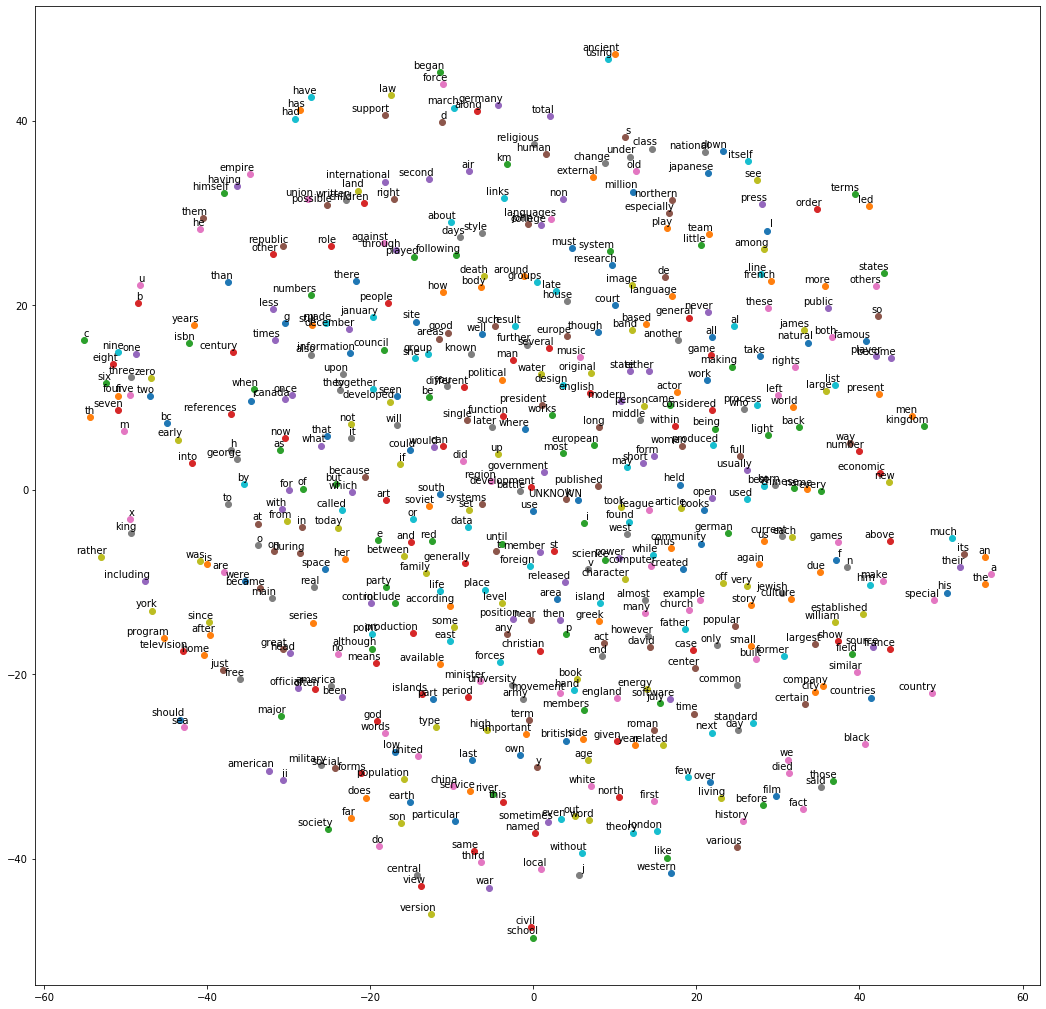

In [220]:
plot_with_labels(low_dim_emds, labels)